In [3]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interactive, fixed, IntSlider


from PIL import Image
from matplotlib.patches import Rectangle

import scipy.signal as ss
import soundfile as sf
from IPython.display import display
from IPython.display import Audio

## 1 Vzorek siglálů

tbd

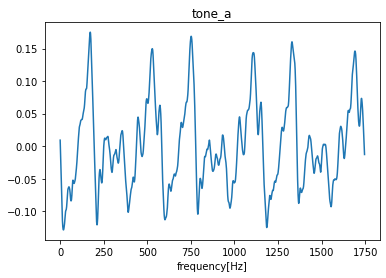

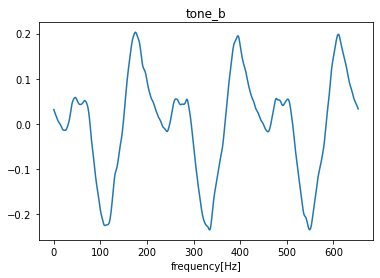

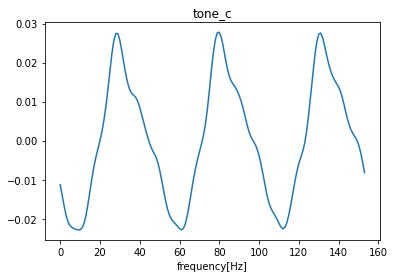

In [17]:
MIDIFROM = 24                   #honza's code here
MIDITO = 108
SKIP_SEC = 0.25
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2
howmanytones = MIDITO - MIDIFROM + 1
tones = np.arange(MIDIFROM, MIDITO+1)
s, Fs = sf.read("klavir.wav")
N = int(Fs * HOWMUCH_SEC)
Nwholetone = int(Fs * WHOLETONE_SEC)
xall = np.zeros((MIDITO+1, N))  # matrix with all tones - first signals empty,
                                # but we have plenty of memory ...
samplefrom = int(SKIP_SEC * Fs)
sampleto = samplefrom + N

for tone in tones:
    x = s[samplefrom:sampleto]
    x = x - np.mean(x) # safer to center ...
    xall[tone,:] = x
    samplefrom += Nwholetone
    sampleto += Nwholetone
    

#sf.write("a_orig.wav", xall[40], Fs)
#sf.write("b_orig.wav", xall[57], Fs)
#sf.write("c_orig.wav", xall[82], Fs)
plt.plot(xall[40][0:int(3*Fs//82.41)])
plt.title("tone_a")
plt.xlabel("frequency[Hz]")
plt.show()
plt.plot(xall[57][0:int(3*Fs//220.00)])
plt.title("tone_b")
plt.xlabel("frequency[Hz]")
plt.show()
plt.plot(xall[82][0:int(3*Fs//932.33)])
plt.title("tone_c")
plt.xlabel("frequency[Hz]")
plt.show()



##  DFT 

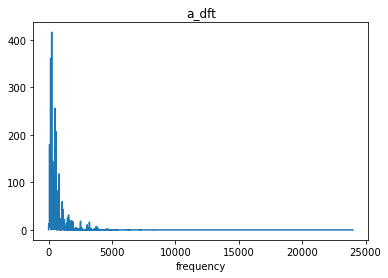

In [5]:
#tone_a
a_dft = xall[40]
a_dft = np.fft.fft(a_dft)
a_dft = np.abs(a_dft)
idk = np.arange(a_dft.size)*Fs / (a_dft.size)

plt.plot(idk[:a_dft.size//2], a_dft[:a_dft.size//2])
plt.title("a_dft")
plt.xlabel("frequency[Hz]")
plt.show()

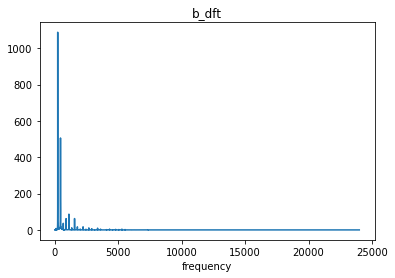

In [9]:
#tone_b
b_dft = xall[57]
b_dft = np.fft.fft(b_dft)
b_dft = np.abs(b_dft)
idk = np.arange(b_dft.size)*Fs / (b_dft.size)

plt.plot(idk[:b_dft.size//2], b_dft[:b_dft.size//2])
plt.title("b_dft")
plt.xlabel("frequency[Hz]")
plt.show()

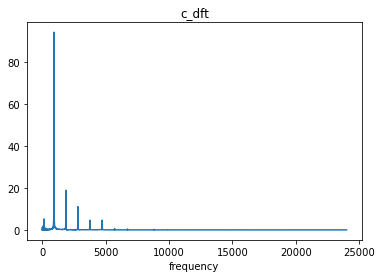

In [14]:
#tone_c
c_dft = xall[82]
c_dft = np.fft.fft(c_dft)
c_dft = np.abs(c_dft)
idk = np.arange(c_dft.size)*Fs / (c_dft.size)

plt.plot(idk[:c_dft.size//2], c_dft[:c_dft.size//2])
plt.title("c_dft")
plt.xlabel("frequency[Hz]")
plt.show()

In [18]:

i = 24
for tone in xall[i:]:
    autocorr = np.correlate(tone, tone, mode = 'full')
    autocorr = autocorr[autocorr.size//2:]
    b1 = ss.find_peaks(autocorr, max(autocorr)//1.85)[0][0]
    b2 = ss.find_peaks(autocorr, max(autocorr)//1.85)[0][1]


    #print(i, Fs/(b2-b1), file=open("output.txt", 'a'))
    i += 1


KeyboardInterrupt: 

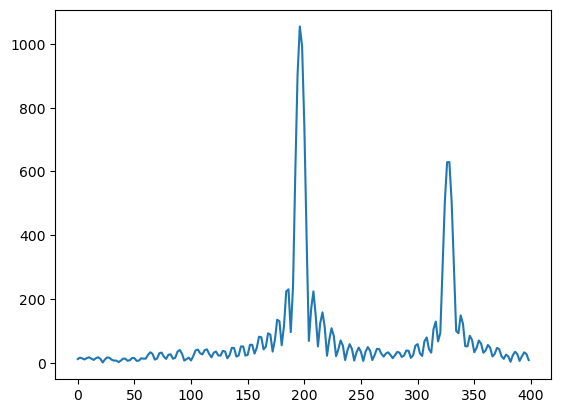

TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
#DTFT i guess
a = xall[24]
all_dft = np.fft.fft(a)
X = np.arange(0, int(all_dft.size/2)+1)
mag = np.abs(all_dft[X])
f = X/all_dft.size*Fs


RANGE = 50
FREQPOINTS = 200
fmax = f[np.argmax(mag)]
fsweep = np.linspace(fmax - RANGE, fmax + RANGE, FREQPOINTS)


n = np.arange(0, all_dft.size)
A = np.zeros([FREQPOINTS, N],dtype=complex)   
for k in np.arange(0,FREQPOINTS):
    A[k,:] = np.exp(-1j * 2 * np.pi * fsweep[k] / Fs * n)     # norm. omega = 2 * pi * f / Fs ... 
    
Xdtft = np.matmul(A,a.T)

precisefmax = fsweep[np.argmax(np.abs(Xdtft))]

plt.plot(f[0:Xdtft.size], abs(Xdtft))
plt.show()

dtft = abs(Xdtft)
d1 = ss.find_peaks(dtft[dtft.size//2:], max(dtft[dtft.size//1.85:])//1.85)[0][0]
d2 = ss.find_peaks(dtft[dtft.size//2:], max(dtft[dtft.size//1.85:])//1.85)[0][1]
print(1/(d2-d1)*Fs)

